# 3. fitting

Together, the data and `bumps` model can be used to fit a scattering profile and extract information about our sample. We will use the example data provided in `../example_data/sphere.csv` to fit a `sphere` model and determine the radius of the spherical particles in our system.

In [2]:
from bumps.names import Parameter, inf
from bumps.fitters import fit

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sasmodels
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment

import bumps

# uncomment and edit line below to add path to the sasview source code
# sys.path.append("/path/to/sasview/src")
import sas

Loading the `sphere.csv` data.

In [3]:
data_np = np.loadtxt('../example_data/sphere.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

Setting up the `bumps` model with information about our system.

In [4]:
kernel = sasmodels.core.load_model("sphere")

scale = Parameter(0.5, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

radius = Parameter(250, limits=(0,inf), name='radius').range(0,5000)
radius_pd = Parameter(0.01, limits=(0,inf), name='radius')
radius_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             sld=sld,
             sld_solvent=sld_solvent,
             radius=radius,
             radius_pd=radius_pd,
             radius_pd_type=radius_pd_type
             )

To fit the data using our model, we need to setup a `bumps` Experiment and FitProblem. They will connect your data with the model and setup the system for fitting. Finally, the fit can be started with the `bumps.fitters.fit` function.

final chisq 22393.7616(35)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                   incoherent background 0.052665(38)    0.05266544(25) 
                                  radius 247.50382(94)   247.5038185(63)
                                   scale 0.9999689487(32) 0.999968948735(21)


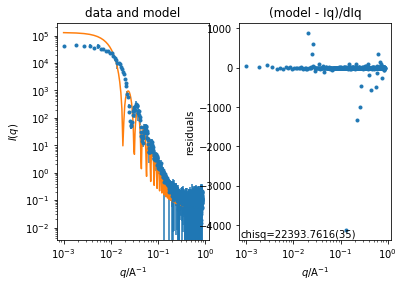

In [5]:
experiment = sasmodels.bumps_model.Experiment(data=data, model=model)
problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()

We can see in the above model that the fit is very close to reproducing the data, however, the polydispersity (as shown by the "bounces" in the mid-q region) is still too low. Setting a higher polydispersity value would lower the depth of these dips and bettter recreate the data. This is also potentially limiting the accuracy of our radius.

Try modifying the radius_pd (polydispersity) in the model above from 0.01 to somewhere between 0.03 and 0.07 to see if you can find a better fit.

To access the results for the fit parameters, you can utilize the `results` of the fit:

In [6]:
results.x # resulting value

array([5.26654404e-02, 2.47503818e+02, 9.99968949e-01])

In [7]:
results.dx # chi squared

array([3.78784726e-05, 9.40077124e-04, 3.20388658e-09])

Alternatively, you can access the results in the `bumps` FitProblem since each parameter is an individual instance of the `bumps` Parameter objects and it's value is continuously updated.

In [8]:
problem.fitness.model.state()

{'scale': 0.999968948735204,
 'background': 0.05266544041136379,
 'sld': 0.728,
 'sld_solvent': 5.238,
 'radius': 247.50381846022825,
 'radius_pd': 0.01,
 'radius_pd_n': 35.0,
 'radius_pd_nsigma': 3.0,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'radius_pd_type': 'lognormal'}

You can access the theoretical scattering intensity as determined by the current state of the FitProblem. The resulting array matches the length of the scattering vector, q, from the original data object.

In [9]:
theory_Iq = problem.fitness.theory()

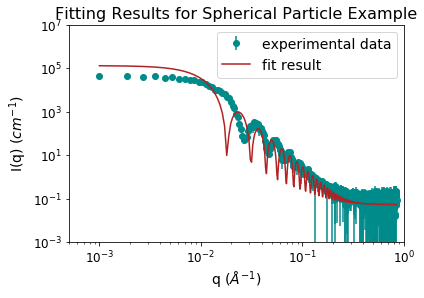

In [10]:
plt.errorbar(data.x, data.y, yerr=data.dy, fmt='o', color='darkcyan', label='experimental data')
plt.errorbar(data.x, theory_Iq, fmt='-', color='firebrick', label='fit result')

# x-axis
plt.xlim(5e-4,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e7)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('Fitting Results for Spherical Particle Example',fontsize=16)
plt.legend(fontsize=14)

plt.show()